<a href="https://colab.research.google.com/github/bassemr/DeepLearningAndGenerativeModelsCourse/blob/main/ex7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a classifier
We will train a classier for the dataset CIFAR10 that contains images belonging to 10 different classes in two ways:
- training a CNN from scratch
- finetuning a CNN

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [121]:
# define transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # random crop with padding
    transforms.RandomHorizontalFlip(),         # flip left/right with 50% chance
    transforms.ToTensor(),                     # convert to tensor [0,1]
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # CIFAR-10 mean
                         (0.2470, 0.2435, 0.2616)) # CIFAR-10 std
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])


# define batch size
batch_size = 32

# load train ds
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# load test ds
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [122]:
print(f"Length of the train dataloader: {len(trainloader)} with batch size {batch_size}")
print(f"Length of the test dataloader: {len(testloader)} with batch size {batch_size}")

Length of the train dataloader: 1563 with batch size 32
Length of the test dataloader: 313 with batch size 32


In [100]:
classes = testset.classes


img shape: torch.Size([32, 3, 32, 32])
labels shape: torch.Size([32])


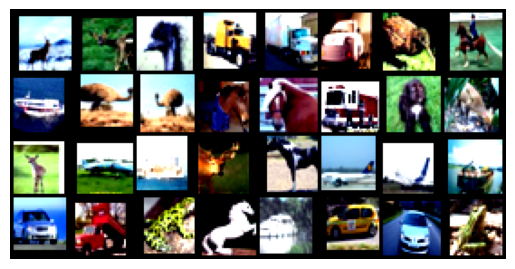

deer deer bird truck truck car bird horse ship bird bird horse horse truck dog deer deer plane ship deer horse plane plane ship car truck frog horse ship car car frog


In [74]:
# show some images
import matplotlib.pyplot as plt

def denorm(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)

to_pil = transforms.ToPILImage()

img, labels = next(iter(trainloader))
print(f"img shape: {img.shape}")
print(f"labels shape: {labels.shape}")
plt.imshow(to_pil(torchvision.utils.make_grid(denorm(img))))
plt.axis("off")
plt.show()

# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [132]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [139]:
# Define a CNN to classify the images
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # first convolutional block
        self.conv_block1 = nn.Sequential(nn.Conv2d(3, 6, kernel_size=5),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2, 2)) # 6x4x14
        # second convolutional block
        self.conv_block2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=5),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2, 2)) # 16x5x5
        # fully connected blocks
        self.fc1 = nn.Sequential(nn.Linear(16 * 5 * 5, 120),
                                nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84),
                                 nn.ReLU())
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x) # bs,16,5,5
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv_block1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [134]:
t = torch.randn(2, 3, 4, 4).to(device)
nn.Flatten()(t).shape, nn.Flatten(1)(t).shape

(torch.Size([2, 48]), torch.Size([2, 48]))

In [25]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

In [135]:
summary(net, input_size=(4, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Net (Net)                                [4, 3, 32, 32]       [4, 10]              --                   True
├─Sequential (conv_block1)               [4, 3, 32, 32]       [4, 6, 14, 14]       --                   True
│    └─Conv2d (0)                        [4, 3, 32, 32]       [4, 6, 28, 28]       456                  True
│    └─ReLU (1)                          [4, 6, 28, 28]       [4, 6, 28, 28]       --                   --
│    └─MaxPool2d (2)                     [4, 6, 28, 28]       [4, 6, 14, 14]       --                   --
├─Sequential (conv_block2)               [4, 6, 14, 14]       [4, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [4, 6, 14, 14]       [4, 16, 10, 10]      2,416                True
│    └─ReLU (1)                          [4, 16, 10, 10]      [4, 16, 10, 10]      --                   --
│    └─MaxPool2d (2)

In [140]:
# define Loss and Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.001)

In [137]:
t = torch.randn(2, 3, 32, 32).to(device)
y_pred = net(t)
y_pred.data, y_pred
#torch.max(y_pred, dim=1)

(tensor([[ 0.1618, -0.0824, -0.0038,  0.0134, -0.0736,  0.0793,  0.0159, -0.0199,
          -0.0106, -0.0229],
         [ 0.1757, -0.0902, -0.0253,  0.0177, -0.0883,  0.0963,  0.0103, -0.0143,
          -0.0098, -0.0655]]),
 tensor([[ 0.1618, -0.0824, -0.0038,  0.0134, -0.0736,  0.0793,  0.0159, -0.0199,
          -0.0106, -0.0229],
         [ 0.1757, -0.0902, -0.0253,  0.0177, -0.0883,  0.0963,  0.0103, -0.0143,
          -0.0098, -0.0655]], grad_fn=<AddmmBackward0>))

In [141]:
# TRAIN!
# put net into train mode
net.train()
for epoch in range(10):  # loop over the dataset multiple times
    train_loss = 0.0
    running_loss = 0.0
    num_samples = 0
    train_acc = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        y_pred = outputs
        y_true = labels

        correct = torch.eq(y_true, y_pred.argmax(dim=1)).sum().item()
        acc = (correct / len(y_pred)) * 100
        train_acc += acc


        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        batch_size = labels.size(0)
        train_loss += loss.item() * batch_size
        num_samples += batch_size
        #if i % 2000 == -1:    # print every 2000 mini-batches
            #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            #running_loss = 0.0
    train_loss /= num_samples
    train_acc /= len(trainloader)

    print(f"Epoch:{epoch+1} Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
print('Finished Training')

Epoch:1 Train loss: 1.80344 | Train accuracy: 32.84%
Epoch:2 Train loss: 1.52159 | Train accuracy: 44.86%
Epoch:3 Train loss: 1.42240 | Train accuracy: 49.01%
Epoch:4 Train loss: 1.36592 | Train accuracy: 51.60%
Epoch:5 Train loss: 1.31470 | Train accuracy: 53.43%
Epoch:6 Train loss: 1.29075 | Train accuracy: 54.63%
Epoch:7 Train loss: 1.28160 | Train accuracy: 54.99%
Epoch:8 Train loss: 1.25861 | Train accuracy: 55.79%
Epoch:9 Train loss: 1.25000 | Train accuracy: 55.95%
Epoch:10 Train loss: 1.24863 | Train accuracy: 56.70%
Finished Training


In [ ]:
# if you want to save the model
PATH = './res/cifar_net.pth'
torch.save(net.state_dict(), PATH)


from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models/res")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "cifar_net.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

In [ ]:
# if you want to load the model
PATH = './res/cifar_net.pth'
net.load_state_dict(torch.load(PATH))

# Evaluate the model
## Evaluation Mode (<code>nn.Module.eval()</code>)
Evaluation mode is not actually a mechanism to locally disable gradient computation, but it is sometimes confused to be such a mechanism.

Functionally, <code>module.eval()</code> (or equivalently <code>module.train(False)</code>) are completely orthogonal to no-grad mode and inference mode. How <code>model.eval()</code> affects your model depends entirely on the specific modules used in your model and whether they define any training-mode specific behavior.

You are responsible for calling <code>model.eval()</code> and <code>model.train()</code> if your model relies on modules such as <code>torch.nn.Dropout</code> and <code>torch.nn.BatchNorm2d</code> that may behave differently depending on training mode, for example, to avoid updating your BatchNorm running statistics on validation data.

It is recommended that you always use <code>model.train()</code> when training and <code>model.eval()</code> when evaluating your model (validation/testing) even if you aren’t sure your model has training-mode specific behavior, because a module you are using might be updated to behave differently in training and eval modes.

## No-grad Mode
Computations in no-grad mode behave as if none of the inputs require grad. In other words, computations in no-grad mode are never recorded in the backward graph even if there are inputs that have <code>require_grad=True</code>.

Enable no-grad mode when you need to perform operations that should not be recorded by autograd, but you’d still like to use the outputs of these computations in grad mode later. This context manager makes it convenient to disable gradients for a block of code or function without having to temporarily set tensors to have <code>requires_grad=False</code>, and then back to <code>True</code>.

In [130]:
# now lets evaluate the model on the test set
correct = 0
total = 0

# put net into evaluation mode
net.eval()

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 59 %


In [131]:
# initialize counters
class_correct = [0] * 10
class_total = [0] * 10

net.eval()  # evaluation mode
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        for i in range(len(labels)):
            label = labels[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1

# print per-class accuracy


for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f'Accuracy of {classes[i]:5s}: {accuracy:.2f} %')


Accuracy of plane: 66.90 %
Accuracy of car  : 75.90 %
Accuracy of bird : 43.60 %
Accuracy of cat  : 50.10 %
Accuracy of deer : 37.60 %
Accuracy of dog  : 48.10 %
Accuracy of frog : 69.90 %
Accuracy of horse: 72.10 %
Accuracy of ship : 65.10 %
Accuracy of truck: 63.10 %


The classifier was able to correctly classify CIFAR10 with a good accuracy, but we can do much better!
HOW?